In [2]:
import gensim.downloader as api
wv = api.load("word2vec-google-news-300")

In [3]:
wv.similarity("good", "great")

np.float32(0.729151)

In [4]:
wv_great = wv["great"]
wv_good = wv["good"]

In [9]:
import pandas as pd
df = pd.read_csv("../14_spacy_textClassification/Fake_Real_Data.csv")
df.head()

,Text,label
0,Top Trump Surrogate BRUTALLY Stabs Him In The...,Fake
1,U.S. conservative leader optimistic of common ...,Real
2,"Trump proposes U.S. tax overhaul, stirs concer...",Real
3,Court Forces Ohio To Allow Millions Of Illega...,Fake
4,Democrats say Trump agrees to work on immigrat...,Real


In [10]:
df.label.value_counts()

label
Fake    5000
Real    4900
Name: count, dtype: int64

In [11]:
df['label_num'] = df.label.map({
    "Fake": 0,
    "Real": 1
})
df.head()

,Text,label,label_num
0,Top Trump Surrogate BRUTALLY Stabs Him In The...,Fake,0
1,U.S. conservative leader optimistic of common ...,Real,1
2,"Trump proposes U.S. tax overhaul, stirs concer...",Real,1
3,Court Forces Ohio To Allow Millions Of Illega...,Fake,0
4,Democrats say Trump agrees to work on immigrat...,Real,1


In [12]:
import spacy
nlp = spacy.load("en_core_web_lg")

In [33]:
def preprocess_and_vectorize(text):
    doc = nlp(text)
    filtered_tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    return wv.get_mean_vector(filtered_tokens)

In [38]:
preprocess_and_vectorize("Don't worry if you dont understand").shape

(300,)

In [35]:
# worry --> []
# not --> []
# understand --> []

# average --> [] ----> sentence embedding

In [36]:
wv.get_mean_vector(["worry", "not", "understand"], pre_normalize=False)[:3]

array([ 0.03483073, -0.03548177, -0.01965332], dtype=float32)

In [37]:
v1 = wv["worry"]
v2 = wv["not"]
v3 = wv["understand"]

import numpy as np
np.mean([v1, v2, v3], axis=0)[:3]

array([ 0.03483073, -0.03548177, -0.01965332], dtype=float32)

In [39]:
df['vector'] = df.Text.apply(preprocess_and_vectorize)
df.head()

,Text,label,label_num,vector
0,Top Trump Surrogate BRUTALLY Stabs Him In The...,Fake,0,"[0.0085234195, 0.019263458, -0.010577418, 0.03..."
1,U.S. conservative leader optimistic of common ...,Real,1,"[0.00861828, 0.007408227, 0.0007675802, 0.0138..."
2,"Trump proposes U.S. tax overhaul, stirs concer...",Real,1,"[0.01793007, 0.006029178, -0.0054984074, 0.038..."
3,Court Forces Ohio To Allow Millions Of Illega...,Fake,0,"[0.0124946935, 0.0121258395, -0.00019833064, 0..."
4,Democrats say Trump agrees to work on immigrat...,Real,1,"[-0.002259819, 0.01164962, 0.0036556108, 0.028..."


In [40]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df.vector,
    df.label_num,
    test_size=0.2,
    random_state=2025,
    stratify=df.label_num
)

In [43]:
print("Shape of X_train before reshaping:", X_train.shape)
print("Shape of X_test before reshaping:", X_test.shape)

X_train_2d = np.stack(X_train)
X_test_2d = np.stack(X_test)

print("Shape of X_train after reshaping:", X_train_2d.shape)
print("Shape of X_test after reshaping:", X_test_2d.shape)

Shape of X_train before reshaping: (7920,)
Shape of X_test before reshaping: (1980,)
Shape of X_train after reshaping: (7920, 300)
Shape of X_test after reshaping: (1980, 300)


In [46]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

clf = GradientBoostingClassifier()
clf.fit(X_train_2d, y_train)
y_pred = clf.predict(X_test_2d)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1000
           1       0.98      0.98      0.98       980

    accuracy                           0.98      1980
   macro avg       0.98      0.98      0.98      1980
weighted avg       0.98      0.98      0.98      1980



In [47]:
test_news = [
    "The Reserve Bank of India announced that it will maintain the current repo rate for the third consecutive quarter, citing moderating inflation and stable economic growth. The central bank said it remains cautious about global oil price volatility and geopolitical risks affecting supply chains.",
    "Researchers at the Indian Institute of Science have developed a low-cost water purification membrane using biodegradable polymers. The team claims the technology can reduce filtration costs by nearly 40% and could be deployed in rural regions within the next year.",
    "A small Himalayan village reported that a 9-year-old boy has developed the ability to predict earthquakes hours before they occur. Local officials claim the child correctly forecasted three tremors last month, and scientists are “studying the phenomenon closely."
]

test_news_vectors = [preprocess_and_vectorize(n) for n in test_news]
clf.predict(test_news_vectors)

array([1, 1, 1])

Text(95.72222222222221, 0.5, 'Truth')

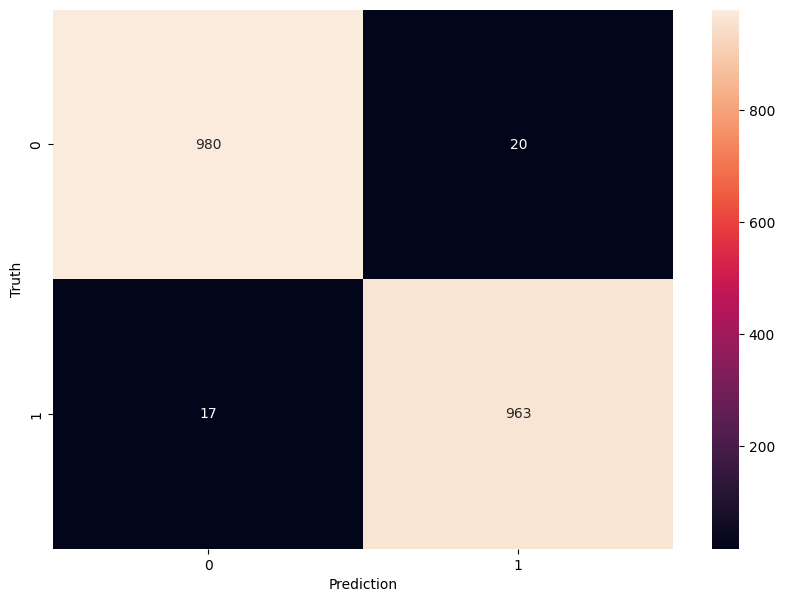

In [48]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

from matplotlib import pyplot as plt
import seaborn as sn

plt.figure(figsize=(10, 7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('Truth')